In [1]:
import xarray as xr
import numpy as np
from openap import top, aero
from matplotlib.colors import TwoSlopeNorm

import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from cartopy.feature import OCEAN, LAND, BORDERS

from openap.top import tools
from openap.top import vis


## Load grid cost data

Here, I use the climate aCCF data as the test. The trajectory will minimize the climate effort from contrails.

Data can be download from: https://surfdrive.surf.nl/files/index.php/s/rFlbrNqqjKowtR6

(Note: this is not a good source of grid cost function for trajectory optimization, because the values are very small and my auto-scaling may not always work. refer to the the `simulated` cost grid for better example.)

In [2]:
d = xr.open_dataset("../tmp/climaccf_20180601.nc")

df_cost = (
    d.to_dataframe()
    .query("-10<longitude<30 and 35<latitude<60 and level<800")
    .reset_index()
    .assign(h=lambda d: aero.h_isa(d.level * 100))
    .query("time=='2018-06-01T06:00:00'")
    .sort_values(["h", "latitude", "longitude"])
    .assign(cost_contrail=lambda d: d.aCCF_nCont / d.aCCF_nCont.mean())
)

df_cost.describe()


,longitude,latitude,level,pcfa,aCCF_CH4,aCCF_O3,aCCF_H2O,aCCF_nCont,aCCF_CO2,aCCF_merged,h,cost_contrail
count,69678.000000,69678.000000,69678.000000,69678.000000,6.967800e+04,6.967800e+04,6.967800e+04,6.967800e+04,6.967800e+04,6.967800e+04,69678.000000,69678.000000
mean,10.000000,47.500000,402.777778,0.038176,-4.593323e-13,9.158029e-12,3.955446e-15,7.031363e-14,6.523598e-15,1.348123e-13,8171.883504,1.000000
std,11.401836,7.071119,220.463359,0.191621,1.906687e-13,4.690795e-12,2.657181e-15,3.829596e-13,0.000000e+00,7.594539e-14,4330.389943,5.446450
min,-9.500000,35.500000,100.000000,0.000000,-7.502517e-13,3.928773e-12,1.957521e-15,0.000000e+00,6.523600e-15,5.459271e-14,2204.227789,0.000000
25%,0.000000,41.500000,200.000000,0.000000,-6.352625e-13,5.295104e-12,2.224985e-15,0.000000e+00,6.523600e-15,7.852978e-14,4206.422428,0.000000
50%,10.000000,47.500000,375.000000,0.000000,-4.813393e-13,7.468836e-12,2.397154e-15,0.000000e+00,6.523600e-15,1.102625e-13,7651.347360,0.000000
75%,20.000000,53.500000,600.000000,0.000000,-3.007249e-13,1.256621e-11,6.146537e-15,0.000000e+00,6.523600e-15,1.803447e-13,11783.469734,0.000000
max,29.500000,59.500000,775.000000,1.000000,-8.789890e-14,2.090578e-11,1.323475e-14,3.882129e-12,6.523600e-15,6.845796e-13,16179.142683,55.211609


## Set up the new objective function

General steps to set you own objective function / cost grid:

1. generate the interpolate model (linear) based on the grid data
2. define the objective function
3. pass the new objective function and interplant model to optimizer's `trajectory()` generator

(Note: this process can take a while, ~1 minute with a modern computer)

In [3]:
optimizer = top.Cruise("A320", "EHAM", "LGAV", m0=0.9)
optimizer.init_conditions(h_min=32_000 * aero.ft, h_max=36_000 * aero.ft)
optimizer.fix_cruise_altitude()
optimizer.setup_dc(nodes=60)
optimizer.debug = False


interp_ccf = tools.interp_grid(
    df_cost.longitude.unique(),
    df_cost.latitude.unique(),
    df_cost.h.unique(),
    df_cost.cost_contrail,
    shape="linear",
)


def obj_ccf(x, u, dt, **kwargs):
    cost = optimizer.obj_grid_cost(x, u, dt, **kwargs)
    fuel = optimizer.obj_fuel(x, u, dt, **kwargs)
    return cost * fuel


flight = optimizer.trajectory(
    objective=obj_ccf,
    interpolant=interp_ccf,
    h_min=32_000 * aero.ft,
    h_max=36_000 * aero.ft,
)


## Visualize the trajectory

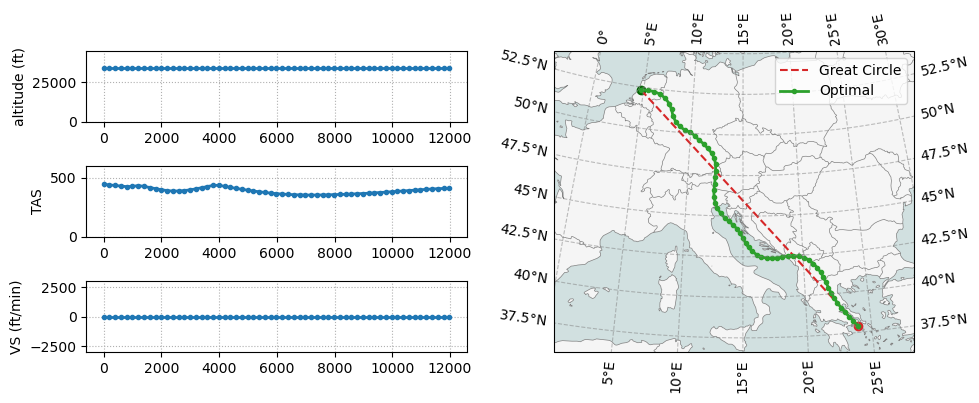

In [4]:
vis.trajectory(flight)
plt.show()


### Visualize with the cost grid

Note: the contrail cost visualized is not exactly the flight level of the optimal trajectory.

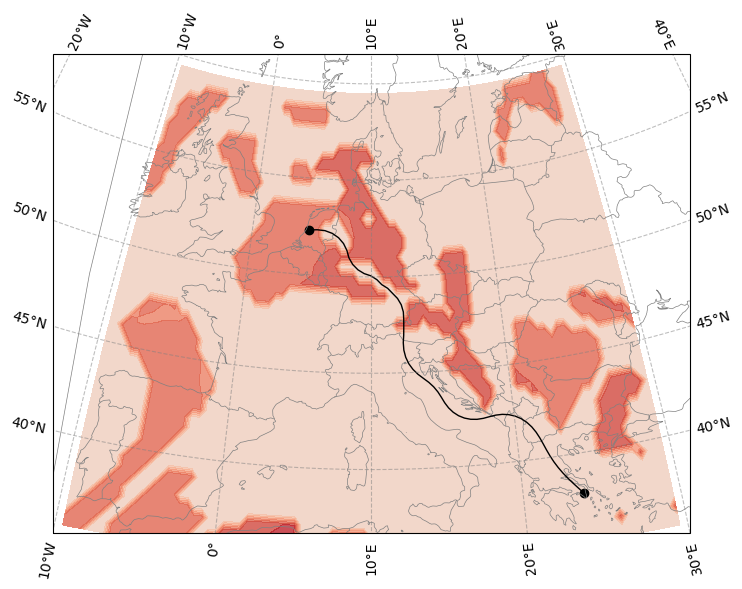

In [5]:
idx = np.abs(df_cost.h.unique() - flight.h.mean()).argmin()
level = df_cost.level.unique()[idx]

fig, ax = plt.subplots(
    1,
    1,
    figsize=(8, 6),
    subplot_kw=dict(
        projection=ccrs.TransverseMercator(central_longitude=10, central_latitude=50)
    ),
)

vmin = df_cost.aCCF_merged.min()
vmax = df_cost.aCCF_merged.max()


ax.set_extent([-10, 30, 35, 60])
ax.add_feature(BORDERS, lw=0.5, color="gray")
ax.gridlines(draw_labels=True, color="gray", alpha=0.5, ls="--")
ax.coastlines(resolution="50m", lw=0.5, color="gray")

df_cost_pivot = df_cost.query(f"level=={level}").pivot(
    index="latitude", columns="longitude", values="aCCF_merged"
)

lat, lon, val = df_cost_pivot.index.values, df_cost_pivot.columns.values, df_cost_pivot.values

ax.contourf(
    lon,
    lat,
    val,
    transform=ccrs.PlateCarree(),
    alpha=0.8,
    cmap="coolwarm",
    norm=TwoSlopeNorm(0),
)

h = aero.h_isa(level * 100)
f = flight.query(f"{h-500}<h<{h+500}")

ax.plot(flight.lon, flight.lat, color="k", lw=1, transform=ccrs.PlateCarree())

ax.scatter(flight.lon.iloc[0], flight.lat.iloc[0], c="k", transform=ccrs.PlateCarree())
ax.scatter(flight.lon.iloc[-1], flight.lat.iloc[-1], c="k", transform=ccrs.PlateCarree())

plt.tight_layout()
